#### Load the libraries

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
import gensim
import numpy as np
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.corpora import Dictionary
# from gensim.models.wrappers import LdaMallet


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

### Connect to drive to get the data

In [3]:
import pandas as pd
df_news = pd.read_pickle("udemy_reviews.pkl")
# Aplica pos/neg
df_news['tag']=df_news['rating'].apply(lambda x: 'pos' if x >= 4 else 'neg')
# Filtra los que solamente dicen una palabra (ej. "Excelente!")
df_news = df_news[df_news['comment'].str.contains("\s")]
# Filtra los que dicen menos de 12 letras (ej. "Excelente!")
df_news = df_news[df_news['comment'].str.len() >= 12]
df_news = df_news[df_news['tag']=='neg']#.sample(2000)
df_news[df_news['tag']=='neg'].sample(10)


# Recomendación:
# usar los comentarios con >=5 palabras


,id,course,rating,comment,user,tag
65776,72845978,1229836,2.5,"Si y el curso no es malo. Lo malo es no poder practicar los paso a paso, por no tener un usuario de Sap.",Martin Gonzalez,neg
5265,33592738,1175904,3.5,"El curso cumple con mis expectativas hasta el momento, pero es complicado ciertos casos como los command que me tomó mas tiempo del pensado con investigación adicional por la diferencia de versión de Visual Studio.",Christian Rodas,neg
20257,92181072,2539838,3.0,Buena eleccion,Martin Gabriel,neg
8783,42815120,2514922,2.0,Le hubiera puesto un caso practico y no se escucha el audio en la sección 2 en tema de ambiente de estudio,Elizabeth Nina Calle,neg
30146,14482184,1512696,3.5,Es muy bueno,Francis Chinchilla,neg
27760,12857532,935680,3.5,"Muy útil el curso, ayuda a introducir al mundo de Tableau.",José Valdivia,neg
58071,36474674,400464,2.5,Se deberia considerar una leyenda sobre las abreviaturas,Giovanni Angeles,neg
36566,11350540,899474,3.0,falta más contenido,Nicolas Jose Milia,neg
60461,51196578,1566774,3.0,"Se que es un curso de introducción, pero estaría bien que se hablara del mismo tema de ambos S.O., como por ejemplo nos enseño de usuarios en Linux, que sea lo mismo en Windows.\nPero estuvo chido, gracias. Saludos.",Sara Lilia Olvera Villegas,neg
52463,71775522,814594,3.0,falta explicacion,Kateryn,neg


In [4]:
df_news['tag'].value_counts()

neg    21448
Name: tag, dtype: int64

In [5]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21448 entries, 6545 to 80394
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       21448 non-null  int64  
 1   course   21448 non-null  int64  
 2   rating   21448 non-null  float64
 3   comment  21448 non-null  object 
 4   user     21448 non-null  object 
 5   tag      21448 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 1.1+ MB


#Data Preprocessing

We defined a list of custom words to be exclude from our dataset

Create the cleaner function to clean the spanish text, remove non alpha numeric characters, remove duplicate, remove spanish accutes, remove digits

In [6]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Faolin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Faolin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
st = ['aaaaa','asd','asdadsad']
y = ['aa','bbb','ccc']
[x for x in st if any(string for string in y if string in x)]


['aaaaa']

In [8]:
from nltk import word_tokenize
from nltk.corpus import stopwords
stop = set(stopwords.words('spanish'))

black_list = ['excelen', 'buen',
              'muchas', 'graci'
              ]

additional_stopwords=set(black_list)

stopwords_sp = stop.union(additional_stopwords)

from nltk.stem import SnowballStemmer
spanish_stemmer = SnowballStemmer('spanish')
def stemmization(texts):
    texts = re.sub(r"""
                   [,.;@#?!&$]+  # Accept one or more copies of punctuation
                   \ *           # plus zero or more copies of a space,
                   """,
                   " ",          # and replace it with a single space
                   texts, flags=re.VERBOSE)
    return spanish_stemmer.stem(texts).split()


import spacy
nlp = spacy.load('es_core_news_md')
def lemmatization(texts, allowed_postags=['NOUN']):
    #x = nlp(texts)
    #print([(xx.text,xx.pos_) for xx in x])
    texts_out = [ token.text for token in nlp(texts) if token.pos_ in 
                 allowed_postags and token.text not in black_list and len(token.text)>2]
    return texts_out

In [9]:
%%time
bigram = gensim.models.Phrases(df_news['comment'].to_list()) 

Wall time: 3.51 s


In [10]:
def cleaner(word):
    word = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', '', word, flags=re.MULTILINE)
    word = re.sub(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)', "", word)
    word = re.sub(r'ee.uu', 'eeuu', word)
    word = re.sub(r'\#\.', '', word)
    word = re.sub(r'\n', '', word)
    word = re.sub(r',', ' ', word)
    word = re.sub(r'\-', ' ', word)
    word = re.sub(r'\.{3}', ' ', word)
    word = re.sub(r'a{2,}', 'a', word)
    word = re.sub(r'é{2,}', 'é', word)
    word = re.sub(r'i{2,}', 'i', word)
    word = re.sub(r'ja{2,}', 'ja', word) 
    word = re.sub(r'á', 'a', word)
    word = re.sub(r'é', 'e', word)
    word = re.sub(r'í', 'i', word)
    word = re.sub(r'ó', 'o', word)
    word = re.sub(r'ú', 'u', word)  
    word = re.sub('[^a-zA-Z]', ' ', word)
    wordlist = [ token for token in nltk.word_tokenize(word) if token.lower() not in stopwords_sp and len(token)>3 ]
    wordlist = [x for x in wordlist if not any(string for string in black_list if string in x)]
    word = " ".join(wordlist)
    list_word_clean = []
    for w1 in word.split(r"\s"):
        if  w1.lower() not in stopwords_sp:
            list_word_clean.append(w1.lower())

    bigram_list = bigram[list_word_clean]
    out_text = stemmization(" ".join(bigram_list))
    return out_text

In [11]:
cleaner('hola soy un gérmen y tendría pulgas. Pero no,creo que no. O si. excelente! excelente')

['hola', 'germen', 'tendria', 'pulgas', 'cre']

Create the function for select **only nouns** for our data, this way we are removing adverb, adjetives, verbs, etc. This is doing with spacy

For gensim we need a list of text, so we need do convert the dataframe to list

In [12]:
stemmization('hola soy un gérmen y tendría pulgas. Pero no,creo que no. O si')

['hola',
 'soy',
 'un',
 'germen',
 'y',
 'tendria',
 'pulgas',
 'pero',
 'no',
 'creo',
 'que',
 'no',
 'o',
 'si']

In [13]:
lemmatization('hola soy un gérmen y tendría pulgas. Pero no,creo que no. O si')

['hola', 'gérmen', 'pulgas']

In [14]:
len(df_news)

21448

In [15]:
# !python -m spacy download es_core_news_md

In [16]:
df_news['comment'].sample(3)

16408    Es un curso introductorio como su nombre lo indica. No es para quién tenga un mínimo de experiencia. De lo contrario no le resultará productivo.
17063                                                                                                    no cumple con lo esperado, código desactualizado
2592                                                                                                                        Faltan ejemplos más complejos
Name: comment, dtype: object

In [17]:
cleaner(df_news['comment'].iloc[3])

['excelente',
 'detallado',
 'menos',
 'leido',
 'calidad',
 'seria',
 'superior',
 'tema',
 'explicar',
 'leer',
 'men']

The Cleaner function work properly

##### Let's clean all the text

In [18]:
from tqdm.notebook import tqdm
tqdm.pandas()

df_news['comment_cleaned'] = df_news['comment'].apply(cleaner)

Now we need to build the *corpus* and the *dictionary* that gensim need to work, to do that we need to pass a list of list of tokens

In [ ]:
# las palabras "curso,clase" son stopwords

In [19]:
df_news['comment_cleaned'].iloc[200:210]

3392                                                                                                                                                                                                                                   [concierne, curso, gusta, directamente, grano, rapido, concis]
3394                                                                                                                                                                                                                                                                                           [curs]
3395    [paso, paso, resolucion, problemas, comunes, digo, espera, usuario, entienda, conceptos, java, cosas, creo, deberian, explicar, segundo, comentario, curso, promete, pense, seria, avanzado, quiza, apresuro, decir, comentario, hibernate, pesar, core, curso, deja, desear, verdad, entend]
3398                                                                                                                  

In [20]:
dictionary = Dictionary(df_news['comment_cleaned'].to_list())
dictionary.compactify()
# Filter extremes
#dictionary.filter_extremes(no_below=5, no_above=0.3)#, keep_n=10000)
#dictionary.filter_extremes(no_below=2, no_above=0.97, keep_n=None)
dictionary.filter_extremes(no_below=5, no_above=0.2, keep_n=None)
dictionary.compactify()

corpus = [dictionary.doc2bow(text) for text in df_news['comment_cleaned'].to_list()]

# MODELADO

Comparando:
Latent Dirichlet Allocation (LDA), 
Latent semantic analysis (LSA), 
Hierarchical Dirichlet Process (HDP)

Para evaluar los topics, usamos **topic coherence** (una medida de interpretación de topics).

In [21]:
%%capture
!pip install pyLDAvis==2.1.2

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
from collections import Counter
import numpy as np
from nltk import word_tokenize, sent_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

import gensim
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
#from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from gensim import corpora

import pyLDAvis.gensim
pyLDAvis.enable_notebook()

import os, re, operator, warnings
warnings.filterwarnings('ignore')  
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Faolin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Faolin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
lsamodel = LsiModel(corpus=corpus, num_topics=25, id2word=dictionary)

In [24]:
lsamodel.print_topics(10,4)

[(0, '0.424*"bien" + 0.220*"solo" + 0.177*"videos" + 0.175*"cosas"'),
 (1, '0.867*"bien" + -0.209*"solo" + -0.143*"videos" + -0.097*"video"'),
 (2, '0.686*"solo" + -0.468*"videos" + 0.247*"explica" + -0.198*"contenido"'),
 (3, '0.607*"videos" + 0.510*"solo" + -0.292*"cosas" + -0.200*"falta"'),
 (4, '0.557*"basico" + -0.504*"cosas" + -0.327*"explica" + -0.188*"videos"'),
 (5, '-0.657*"basico" + -0.335*"videos" + -0.332*"cosas" + 0.282*"falta"'),
 (6, '-0.708*"falta" + -0.271*"hace" + 0.243*"mejor" + -0.223*"explicacion"'),
 (7, '0.545*"cosas" + -0.469*"explica" + 0.251*"mejor" + 0.228*"creo"'),
 (8,
  '0.510*"contenido" + -0.464*"informacion" + 0.430*"mejor" + -0.273*"creo"'),
 (9,
  '0.621*"video" + -0.389*"temas" + 0.296*"explicacion" + -0.245*"contenido"')]

In [25]:
ldamodel = LdaModel(corpus=corpus, num_topics=25, id2word=dictionary, iterations = 2000, passes=10)

In [26]:
ldamodel.print_topics(10, 6)

[(9,
  '0.040*"facil" + 0.037*"graci" + 0.024*"quizas" + 0.024*"super" + 0.021*"palabras" + 0.018*"imagenes"'),
 (21,
  '0.035*"mundo" + 0.035*"conocer" + 0.032*"aburrido" + 0.029*"sabe" + 0.028*"personas" + 0.026*"introductorio"'),
 (0,
  '0.053*"lento" + 0.029*"hablar" + 0.028*"pierde" + 0.023*"linux" + 0.023*"windows" + 0.021*"visual"'),
 (10,
  '0.094*"bi" + 0.052*"paso" + 0.041*"pagina" + 0.040*"ahora" + 0.037*"preguntas" + 0.035*"version"'),
 (4,
  '0.137*"videos" + 0.088*"video" + 0.065*"audio" + 0.039*"calidad" + 0.031*"contenido" + 0.030*"vide"'),
 (16,
  '0.313*"bien" + 0.096*"explica" + 0.048*"explicado" + 0.042*"explic" + 0.030*"bastante" + 0.026*"conceptos"'),
 (18,
  '0.100*"mejor" + 0.095*"podria" + 0.087*"ense" + 0.049*"mejorar" + 0.039*"puede" + 0.028*"creo"'),
 (3,
  '0.209*"curs" + 0.054*"conten" + 0.043*"aprend" + 0.030*"entiendo" + 0.029*"tenia" + 0.028*"clar"'),
 (14,
  '0.072*"programacion" + 0.062*"persona" + 0.037*"corto" + 0.036*"sencillo" + 0.032*"queda" + 0.

 ## Hierarchical Dirichlet process Model

In [27]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary, random_state= 30)

and the topics of this model:

In [28]:
def display_topics(model, model_type="lda"):
    for topic_idx, topic in enumerate(model.print_topics()):
        print ("Topic %d:" % (topic_idx))
        if model_type== "hdp":
            print (" ".join(re.findall( r'\*(.[^\*-S]+).?', topic[1])), "\n")
        else:
            print (" ".join(re.findall( r'\"(.[^"]+).?', topic[1])), "\n")


In [29]:
# hdpmodel.show_topics() 

display_topics(hdpmodel, model_type="hdp")

Topic 0:
bien  solo  habla  video  basico  explica  tiempo  profesor  explicar  hacer 

Topic 1:
bien  solo  ejemplos  ejemplo  falta  hacer  explicacion  videos  mejor  cada 

Topic 2:
videos  bien  solo  hace  contenido  explica  creo  conceptos  video  cosas 

Topic 3:
instructor  bien  explica  creo  cosas  clases  puede  cursos  deberia  agregue 

Topic 4:
bien  cosas  falta  videos  solo  basico  cierta  aunque  luego  mejor 

Topic 5:
bien  creo  solo  receta  tiempo  falta  curs  ordenador  tambien  basico 

Topic 6:
bien  empiezas  contest  preguntas  novatos  talleres  hacer  cosas  convence  esperando 

Topic 7:
familiariz  bien  vienes  qgis  existen  avanzas  hace  pas  navegacion  realizan 

Topic 8:
bien  colocar  explicados  frente  estructura  mejore  aporto  comenzado  frontend  mala 

Topic 9:
bien  cuales  linkedin  limito  deberia  poder  pausada  profesor  tecl  nod 

Topic 10:
aunque  bien  mejorar  maneja  realizar  instructor  videos  basico  falta  metodo 

To

as we could see there are 20 topics, however is kind of dificult to interpret or follow, so we decide to move to another model.





In [30]:
def evaluate_graph(dictionary, corpus, texts, limit, model):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        if model == 'lsi':
            lm = LsiModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        else:
            lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

##LSI MODEL

In [31]:
lsimodel = LsiModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [32]:
display_topics(lsimodel)  # Showing the topics

Topic 0:
bien solo videos cosas explica hace creo hacer contenido basico 

Topic 1:
bien solo videos video hacer explicado hace mejor instructor contenido 

Topic 2:
solo videos explica contenido falta cosas basico mejor habla creo 

Topic 3:
videos solo cosas falta basico creo video explicar bien mejor 

Topic 4:
basico cosas explica solo videos contenido hace ejemplos mejor informacion 

Topic 5:
basico videos cosas falta solo explicacion demasiado informacion ejemplos explica 

Topic 6:
falta hace mejor explicacion instructor basico explica creo videos hacer 

Topic 7:
cosas explica mejor creo solo instructor hace habla video falta 

Topic 8:
contenido mejor temas creo informacion instructor explicacion hacer explica habla 

Topic 9:
video temas informacion videos ejemplos explica basico tema parte explicacion 



It seen that with 10 topics there is some themes with keywords related to: trump, venezuela, police, electiones, terrorism; still is a little difficult to gt some insight, because of this we are trying to select the best number of topics by iterate over a range of values and looking the coherence 

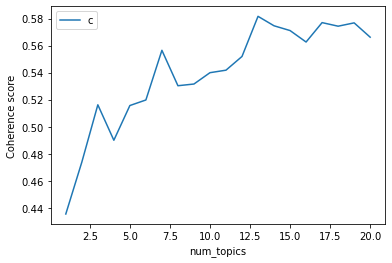

Wall time: 2min 47s


In [33]:
%%time
lmlist_lsi, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=df_news['comment_cleaned'].to_list(), limit=21, model= "lsi")

According to the coherence the best number of topics are between 3-7, however you must select the topics using both the coherence and visual inspection.


In [34]:
display_topics(lmlist_lsi[2])

Topic 0:
bien solo videos cosas explica hace creo hacer contenido basico 

Topic 1:
bien solo videos video hacer explicado hace mejor instructor contenido 

Topic 2:
solo videos explica falta basico contenido habla mejor creo video 



Now, Let's try another model

## Latent Dirichlet Allocation Model

In [35]:
ldamodel = LdaModel(corpus=corpus, num_topics=20, id2word=dictionary)

In [36]:
display_topics(ldamodel)

Topic 0:
bi bien general bastante aunque explica musica fondo entiende esperaba 

Topic 1:
bien explicar forma detalles explica falta conocimientos entrar basicas cosas 

Topic 2:
gratis bien cosas contenido sabe basico  + 0.014*  + 0.014*  + 0.013* 

Topic 3:
curs interesante facil ejempl sido parece poder datos bases basico 

Topic 4:
video palabras mejor podria practico agradece solo clase vamos principi 

Topic 5:
hace haber tiempo genial bien diccion simplemente cada usuario vista 

Topic 6:
bien introduccion explicado basico mucha vide falto corto informacion conocer 

Topic 7:
gratuito programacion preguntas malo codigo videos explica hac tampoco contenidos 

Topic 8:
interes conten audio principiantes bien explica basico entend moment clar 

Topic 9:
sencillo persona deberia programacion lenguaje ense iniciarse explicacion bootstrap ahora 

Topic 10:
contenido videos video version solo calidad util puedo pesar presentacion 

Topic 11:
falta momento claro explicacion profesor ex

Find out the optimal number of topics for the LDA model based on the coherence metric:

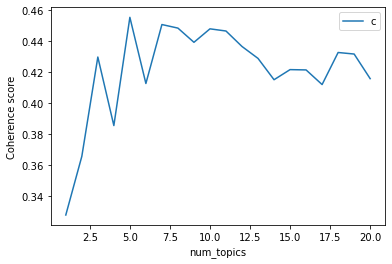

In [37]:
lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=df_news['comment_cleaned'].to_list(), limit=21, model= "lda")

For this model it seems that  9 or 18, again we must to check the keywords too.

### Comparing the Model Coherence of the Best Models

we made 3 models, now let's compare each other's  coherence

In [38]:
ldamodel = lmlist[11]
lsimodel = lmlist_lsi[2]

lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted=False)]

hdptopics = [[word for word, prob in topic] for topicid, topic in hdpmodel.show_topics(formatted=False)]

ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]

In [39]:
lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=df_news['comment_cleaned'].to_list(), dictionary=dictionary, window_size=10).get_coherence()

hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=df_news['comment_cleaned'].to_list(), dictionary=dictionary, window_size=10).get_coherence()

lda_coherence = CoherenceModel(topics=ldatopics, texts=df_news['comment_cleaned'].to_list(), dictionary=dictionary, window_size=10).get_coherence()

<AxesSubplot:>

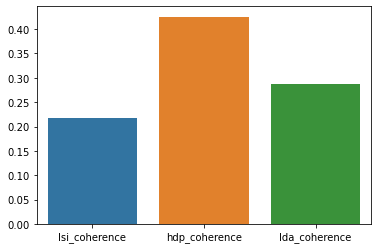

In [40]:
import seaborn as sns

coherences = [lsi_coherence, hdp_coherence, lda_coherence]
n = len(coherences)
x = ['lsi_coherence','hdp_coherence', 'lda_coherence']
sns.barplot(x, coherences)


We can see that the **LdaModel** model **with 8 topics** has the higher value of
coherence

Examine the keyword to get the topics of the best model

In [41]:

display_topics(ldamodel)

Topic 0:
bien falto explica gratuito informacion basico solo comandos explicar mejor 

Topic 1:
explica solo profesor bien  + 0.011*  + 0.010*  + 0.008*  + 0.008*  + 0.008* 

Topic 2:
bien audio paso videos video cosas basic clar mejor excelente 

Topic 3:
explicacion informacion falta puede mejorar conceptos bastante cl creo podria 

Topic 4:
bien explic aprend idea tem mala tutorial preguntas hacer instructor 

Topic 5:
cosas ejemplo tener sencillo hacer debe crear poder bien conocer 

Topic 6:
eleccion bien falta conten instructor entiende hace version explican conoc 

Topic 7:
curs demasiado bas bi ense interesante videos lento parece deberia 

Topic 8:
esperaba ejemplos temas tema bien esper basico falta solo aburrido 

Topic 9:
explicaciones hace mucha teoria faltan solo cada videos estan embargo 

Topic 10:
basico mejor podria creo momento interes gratis bueno ejemplos buena 

Topic 11:
bien programacion conocimientos cosas explicado basico introduccion ahora explica solo 



It looks like the topics are:
* Topic 0: felicitaciones
* Topic 1: expectativas
* Topic 2: experiencia
* Topic 3: contenido
* Topic 4: instructor
* Topic 5: material
* Topic 6: video
* Topic 7: lenguaje
* Topic 8: ejercicios
* Topic 9: titulo
* Topic 10: temas
* Topic 11: explicación


In [42]:
label_dicc = {0:'felicitaciones', 1:'expectativas', 2:'experiencia', 3: 'contenido', 4:'instructor', 5:'material', 6:'video', 
              7:'lenguaje', 8:'ejercicios', 9: 'titulo', 10:'temas', 11:'explicación'}

Let´s check the keyword when we selecting another number of topics (14)

In [43]:
ldamodel_16 =lmlist[16]


In [44]:
display_topics(ldamodel_16)

Topic 0:
vide pract gustaria informacion aunque explicaciones ejercicios interesante falta funcion 

Topic 1:
explicar veces cosas bien gratuito hace basic profesor hecho solo 

Topic 2:
mejor podria mejorar conceptos espero aprender explicacion explican pues esperaba 

Topic 3:
paso bien videos herramienta video musica fondo explica java marketing 

Topic 4:
interes audio bien malo siento esper escucha ahor contenido falta 

Topic 5:
instructor debe clara gusta claro explicacion esfuerzo mejorar solo acceso 

Topic 6:
bi explica parece lento  + 0.012*  + 0.012*  + 0.012*  + 0.011*  + 0.011* 

Topic 7:
explicacion informacion mucha buena video ejemplos cl curs poca falta 

Topic 8:
eleccion bien sido pagina momento conocimientos solo aprendiendo empieza comandos 

Topic 9:
basico conten falta creo basica conoc entrar informacion nivel detall 

Topic 10:
tutorial datos facil base excelente preguntas entend cumple bien sencillo 

Topic 11:
falta tem creo bien conocimiento informacion con

# Classifiying all documents

now that we have been select the best model and topics number, is time to assign a topic to each document, means **cluster** according to the topics

In [45]:
from tqdm.notebook import tqdm_notebook

def format_topics_sentences(ldamodel=0, corpus=corpus, texts=0):
    # Init output
    sent_topics_df = pd.DataFrame()-n

    # Get main topic in each document
    for i, row in tqdm_notebook(enumerate(ldamodel[corpus]), total=len(ldamodel[corpus])):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel, corpus=corpus, texts=df_news['comment_cleaned'].to_list())



  0%|          | 0/21448 [00:00<?, ?it/s]

In [46]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,8.0,0.8690,"esperaba, ejemplos, temas, tema, bien, esper, basico, falta, solo, aburrido","[introduccion, bien, deberian, hacerlo, dirigido, fotos, rp]"
1,1,6.0,0.5417,"eleccion, bien, falta, conten, instructor, entiende, hace, version, explican, conoc","[explican, mayori]"
2,2,2.0,0.3460,"bien, audio, paso, videos, video, cosas, basic, clar, mejor, excelente","[pronto, evaluarlo, comparandolo, calidad, cursos, bajo, pueden, descargar, archivos, estan, sonido, malo, escucha, turbi]"
3,3,6.0,0.4637,"eleccion, bien, falta, conten, instructor, entiende, hace, version, explican, conoc","[excelente, detallado, menos, leido, calidad, seria, superior, tema, explicar, leer, men]"
4,4,1.0,0.5552,"explica, solo, profesor, bien, c, dice, explicar, hace, parece, habla","[parece, podria, algun, peque, repaso, terminos, comunes, ademas, ejempl]"
5,5,10.0,0.3998,"basico, mejor, podria, creo, momento, interes, gratis, bueno, ejemplos, buena","[parte, curso, profesor, mismo, curso, gratis, especializado, hacking, igualmente, bien, explic]"
6,6,10.0,0.5117,"basico, mejor, podria, creo, momento, interes, gratis, bueno, ejemplos, buena","[gusto, hacking, python, aprende, python, hacking]"
7,7,1.0,0.4399,"explica, solo, profesor, bien, c, dice, explicar, hace, parece, habla","[habla, hacking, apartados, solo, decepcion]"
8,8,10.0,0.8363,"basico, mejor, podria, creo, momento, interes, gratis, bueno, ejemplos, buena","[introduccion, breve, rapida, lenguaje, programacion, python, curso, auditoria, informatica, final, curso, breve, ejemplo, hacer, cumplido, exactamente, expectativas, reconocer, tutor, esforzado, involucrado, ejemplos, lenguaj]"
9,9,8.0,0.4119,"esperaba, ejemplos, temas, tema, bien, esper, basico, falta, solo, aburrido","[parecio, super, bien, curso, personas, quieran, iniciarse, lenguaje, programacion, python]"


We selected the ldamodel with 12 topics and asigned a dominant topic to each document, now let map each topic with a label 

first let's create the dictionary

In [47]:
label_dicc = {0:'felicitaciones', 1:'expectativas', 2:'experiencia', 3: 'contenido', 4:'instructor', 5:'material', 6:'video', 
              7:'lenguaje', 8:'ejercicios', 9: 'titulo', 10:'temas', 11:'explicación'}

In [48]:
df_dominant_topic['Dominant_Topic'] = df_dominant_topic['Dominant_Topic'].astype('int64')


In [49]:
df_dominant_topic['Dominant_Topic'] = df_dominant_topic['Dominant_Topic'].map(label_dicc)
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,ejercicios,0.8690,"esperaba, ejemplos, temas, tema, bien, esper, basico, falta, solo, aburrido","[introduccion, bien, deberian, hacerlo, dirigido, fotos, rp]"
1,1,video,0.5417,"eleccion, bien, falta, conten, instructor, entiende, hace, version, explican, conoc","[explican, mayori]"
2,2,experiencia,0.3460,"bien, audio, paso, videos, video, cosas, basic, clar, mejor, excelente","[pronto, evaluarlo, comparandolo, calidad, cursos, bajo, pueden, descargar, archivos, estan, sonido, malo, escucha, turbi]"
3,3,video,0.4637,"eleccion, bien, falta, conten, instructor, entiende, hace, version, explican, conoc","[excelente, detallado, menos, leido, calidad, seria, superior, tema, explicar, leer, men]"
4,4,expectativas,0.5552,"explica, solo, profesor, bien, c, dice, explicar, hace, parece, habla","[parece, podria, algun, peque, repaso, terminos, comunes, ademas, ejempl]"
5,5,temas,0.3998,"basico, mejor, podria, creo, momento, interes, gratis, bueno, ejemplos, buena","[parte, curso, profesor, mismo, curso, gratis, especializado, hacking, igualmente, bien, explic]"
6,6,temas,0.5117,"basico, mejor, podria, creo, momento, interes, gratis, bueno, ejemplos, buena","[gusto, hacking, python, aprende, python, hacking]"
7,7,expectativas,0.4399,"explica, solo, profesor, bien, c, dice, explicar, hace, parece, habla","[habla, hacking, apartados, solo, decepcion]"
8,8,temas,0.8363,"basico, mejor, podria, creo, momento, interes, gratis, bueno, ejemplos, buena","[introduccion, breve, rapida, lenguaje, programacion, python, curso, auditoria, informatica, final, curso, breve, ejemplo, hacer, cumplido, exactamente, expectativas, reconocer, tutor, esforzado, involucrado, ejemplos, lenguaj]"
9,9,ejercicios,0.4119,"esperaba, ejemplos, temas, tema, bien, esper, basico, falta, solo, aburrido","[parecio, super, bien, curso, personas, quieran, iniciarse, lenguaje, programacion, python]"


In [50]:
df_news['labels'] = df_dominant_topic['Dominant_Topic']
df_news['label_confidence'] = df_dominant_topic['Topic_Perc_Contrib']

Let's examine some text and its topics

In [51]:
df_news[['comment', 'labels']].head(10)

,comment,labels
6545,como introducción esta bien pero deberían de hacerlo mas dirigido a RPA con fotos de RPAS,lenguaje
6734,Explican poco... se lee la mayoría,expectativas
6738,"es muy pronto para evaluarlo, comparandolo con la calidad de otros cursos este es bajo, no se pueden descargar los archivos ya que no estan en PDF y el sonido es malo, se escucha turbio.",temas
6739,"Excelente, muy detallado. Si fuera menos « leído » la calidad sería superior! El tema da para explicar más y leer menos",ejercicios
6782,"Me parece que podria dar algun pequeño repaso de terminos comunes, ademas de dar mas ejemplos",temas
7061,Una parte del curso fue algo que el profesor mismo tiene en otro curso gratis.\nPero lo especializado a Hacking está igualmente bien explicado.,video
7084,"No me gusto. Más que Hacking con Python... era aprende Python, de hacking poco y nada.",material
7088,habla de hacking y son dos apartados que solo son web. DECEPCIONANTE.,temas
7113,"Es una introducción breve y rápida al lenguaje de programación Python. No es un curso de Auditoria informática, ya que al final del curso se da un breve ejemplo de como hacer Scraping.No ha cumplido exactamente con mis expectativas pero he de reconocer que el tutor se ha esforzado e involucrado en los ejemplos del lenguaje.",explicación
7115,Me pareció super bien el curso para las personas que quieran iniciarse en el lenguaje de programación python,video


In [52]:
df_news[ df_news['labels'] == 'instructor'].sort_values(by='label_confidence',ascending=False).head(10)

,id,course,rating,comment,user,tag,comment_cleaned,labels,label_confidence
524,19709782,1391682,3.5,"Si, me parece muy instructivo y de necesario saber general",Carlos Figueroa,neg,"[parece, instructivo, necesario, saber, general]",instructor,0.9236
3792,44691334,860984,3.0,muy lenta la explicacion,Hector Ortega,neg,"[lenta, explicacion]",instructor,0.8982
4484,4357028,565188,3.0,por que fue buena,Angelicachoez,neg,[],instructor,0.8691
12050,12183332,1268882,3.0,hubiese sido mejor que es un curso netamente para principiantes...,Hugo del Bosque Campos,neg,"[sido, mejor, curso, netamente, principi]",instructor,0.8473
13968,69209782,2006770,3.0,"Creo que ciertos códigos no están bien encapsulados, como mandar llamar la base de datos desde la vista... con eso arruina por completo el modelo vista controlador.",Tomas Gerardo Nevarez Simental,neg,"[creo, ciertos, codigos, estan, bien, encapsulados, mandar, llamar, base, datos, vista, arruina, completo, modelo, vista, control]",instructor,0.8473
12050,50747862,2175580,3.0,"el entorno de trabajo es adecuado, un poco complejo pero adecuado.\nla cuestión es ir adapatarce a la dinámica de la pagina.\ncreo que es una herramienta muy buena, que estoy aprendiendo a utilizar por temas de clase. gracias",Ubay,neg,"[entorno, trabajo, adecuado, complejo, adecuado, cuestion, adapatarce, dinamica, pagina, creo, herramienta, aprendiendo, utilizar, temas, cl]",instructor,0.8473
3121,86013022,3151202,1.0,"Es un curso terrible, parece que el instructor solo quería actualizar su código de Java a Kotlin sin importarle que no todos los patrones se programan igual. Por lo mismo, nunca menciona cambios importantes al programarlos, y si aprender los patrones de diseño junto con las bondades de Kotlin era tu intención, definitivamente no te lo recomiendo.\nPor otro lado, no tiene el mínimo cuidado en sus presentaciones ni en su código, mala ortografía, cambia de inglés a español en el código y eso, particularmente, me indica que no prepara su lección y está improvisando.\nLos videos están mal recortados, bueno, con todo lo que he mencionado te puedes dar una idea sobre lo que puedes esperar de la explicación y los ejemplos.\nSinceramente, sin duda alguna, en un video de YouTube de 3 minutos te enseñan mejor y sin sentirte timado. \nPor favor, tome esa capacidad de compartir el conocimiento de una forma seria, usted puede impactar a miles de personas en una forma negativa.",Benjamin Morales,neg,"[curso, terrible, parece, instructor, solo, queria, actualizar, codigo, java, kotlin, importarle, patrones, programan, igual, mismo, nunca, menciona, cambios, importantes, programarlos, aprender, patrones, dise, junto, bondades, kotlin, intencion, definitivamente, recomiendo, lado, minimo, cuidado, presentaciones, codigo, mala, ortografia, cambia, ingles, espa, codigo, particularmente, indica, prepara, leccion, improvisando, videos, estan, recortados, mencionado, puedes, idea, puedes, esperar, explicacion, ejemplos, sinceramente, duda, alguna, video, youtube, minutos, ense, mejor, sentirte, timado, favor, tome, capacidad, compartir, conocimiento, forma, seria, usted, puede, impactar, miles, personas, forma, neg]",instructor,0.8472
4530,3359778,565188,1.5,"Demasiados errores y falta de explicación, podría hacer cosas de manera mas fáciles y se va por las difíciles o mas complicadas",Alvaro Baca,neg,"[demasiados, errores, falta, explicacion, podria, hacer, cosas, manera, faciles, dificiles, complic]",instructor,0.8472
16189,91615412,1218500,3.5,"Buen curso, estan todos los conceptos básicos bien resumidos y explicados. \nFaltaron mas elementos diferenciadores con respecto a otros cursos, quizás más ejemplos prácticos",pablo cuevas,neg,"[curso, estan, conceptos, basicos, bien, resumidos, explicados, faltaron, elementos, diferenciadores, respecto, cursos, quizas, ejemplos, pract]",instructor,0.8472
60,74609448,244414,3.5,me ha hecho analizar personalmente como debemos manejar el tema sobre todo en la educación y el conoci

In [53]:
df_news.sort_values(by='label_confidence',ascending=False).head(10)

,id,course,rating,comment,user,tag,comment_cleaned,labels,label_confidence
1961,77318140,3675456,1.0,"La verdad en el tema 5 minuto 14 aproximadamente esta mal editado, incluso la facilitadora dice una mala palabra debieron haber editado bien este video. Por favor tomen esto como algo constructivo. Gracias",Alejandro Torres,neg,"[verdad, tema, minuto, aproximadamente, editado, incluso, facilitadora, dice, mala, palabra, debieron, haber, editado, bien, video, favor, tomen, constructivo, graci]",felicitaciones,0.9563
10870,82709850,1558846,3.0,"Me siento un poco decepcionado por la ,amera en la que ha sido diseñado, me parece muy básico el como se termino el proyecto....",Guery Mamani Chambi,neg,"[siento, decepcionado, amera, sido, dise, parece, basico, termino, proyect]",material,0.9461
10870,24622266,291766,3.0,"Si pero lo veo un poco lento, pero esta bien",Luis Díaz Hernández,neg,"[lento, bi]",material,0.9461
752,51098952,2518830,2.5,"Las explicaciones no llevan un orden especifico, son explicaciones generales sin ahondar ni aclarar muchas veces como se hacen las cosas.",Alf,neg,"[explicaciones, llevan, orden, especifico, explicaciones, generales, ahondar, aclarar, veces, hacen, c]",temas,0.9427
11078,75800096,1192848,3.5,"Los materiales son buenos y utiles, y como repaso de programacion esta genial. Creo que es bueno si ya tienes un poco de nocion, ya que hay cosas que dan por sentadas y dado que esto es fundamentos de programacion no todos podrian saberlo.",César Delgadillo,neg,"[materiales, utiles, repaso, programacion, genial, creo, nocion, cosas, sentadas, dado, fundamentos, programacion, podrian, sab]",temas,0.9427
1735,46357258,1747432,1.5,"Lo he comprado hoy mismo, y no estaba seguro, primero porque son solo 2 horas y sabia de antemano que hablaria muy por encima de las cosas que propone por los comentarios.\n\nDespues de hacerlo tengo que decir que creo que es un curso que se queda a medias y que no propone o dice nada nuevo. Si es verdad que da varios consejos sobre UpWork muy especificos que puede interesar. Pero el curso se presenta mas general de lo que realmente es. Tambien recomienda Wix y Wordpress para hacer el portafolio y no lo menciona en los indices. En general no lo recomiendo.",Jose Ángel Cano Domingo,neg,"[comprado, mismo, seguro, primero, solo, horas, sabia, antemano, hablaria, encima, cosas, propone, comentarios, despues, hacerlo, decir, creo, curso, queda, medias, propone, dice, nuevo, verdad, varios, consejos, upwork, especificos, puede, interesar, curso, presenta, general, realmente, tambien, recomienda, wordpress, hacer, portafolio, menciona, indices, general, recom]",explicación,0.9427
524,19709782,1391682,3.5,"Si, me parece muy instructivo y de necesario saber general",Carlos Figueroa,neg,"[parece, instructivo, necesario, saber, general]",instructor,0.9236
668,60419390,2518830,2.0,"Mala dicción, demasiado tiempo muerto.",Felipe Vidal Araya,neg,"[mala, diccion, demasiado, tiempo, muert]",material,0.9236
884,66177262,3159114,1.0,"En completa humildad, no es el curso que estaba buscando se que puede mejorar el contenido. Gracias de todas maneras.",Henry Baltazar,neg,"[completa, humildad, curso, buscando, puede, mejorar, contenido, gracias, todas, maner]",felicitaciones,0.9167
3996,44517530,796764,3.5,Nivel muy basico para lo que busco.,Paola Lopez,neg,"[nivel, basico, busc]",felicitaciones,0.9167


### let's see the distribution of topics


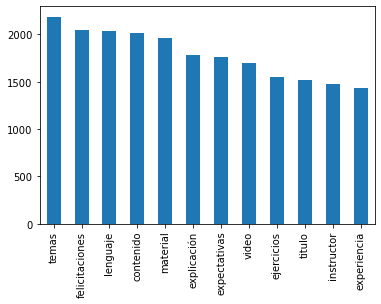

In [54]:
ax = df_dominant_topic['Dominant_Topic'].value_counts().plot(kind='bar')
plt.show()

The topis are almost balanced, so we are good

finally that we have our models set up, as well as analyzed, we can go
ahead to visualizing them.

In [55]:
!pip install pyLDAvis

In [56]:
import pyLDAvis

pyLDAvis.enable_notebook()

In [57]:
# %%time
import pyLDAvis.gensim
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.002593 -0.011264       1        1  11.074179
1      0.056624  0.005407       2        1   9.739823
3     -0.057148  0.039957       3        1   9.067847
10    -0.069138  0.061867       4        1   8.958849
11     0.083591  0.075997       5        1   8.447629
9     -0.033626 -0.020011       6        1   8.252957
0     -0.016179  0.020006       7        1   8.176067
7      0.061437  0.138240       8        1   8.057616
6     -0.056391 -0.129038       9        1   8.026070
2      0.113459  0.065392      10        1   7.040154
8     -0.218688 -0.026407      11        1   6.992303
4      0.133466 -0.220146      12        1   6.166505, topic_info=            Term         Freq        Total Category  logprob  loglift
146  explicacion  1140.000000  1140.000000  Default  30.0000  30.0000
306     eleccion   766.000000   766.000000  Default  29.0000  29.0000
37        explic   457.000000   457.000000  Default  28.0000  28.0000
342         curs   989.000000   989.000000  Default  27.0000  27.0000
0           bien  3217.000000  3217.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
210    contenido    75.837638  1084.791377  Topic12  -5.0153   0.1255
147         hace    74.537779   986.865906  Topic12  -5.0326   0.2028
249      general    65.214831   565.509830  Topic12  -5.1662   0.6260
160         creo    66.339279  1137.649963  Topic12  -5.1491  -0.0559
82        videos    65.266019  1257.492733  Topic12  -5.1654  -0.1724

[901 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
2135      4  0.023445     abarca
2135      9  0.961258     abarca
1834      3  0.973340    abarcar
1551      8  0.952235  abordados
3344      5  0.985025      about
...     ...       ...        ...
2282      1  0.006825    windows
2282      4  0.313951    windows
2282      9  0.013650    windows
2282     10  0.655202    windows
2815      8  0.966796      xampp

[2781 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 4, 11, 12, 10, 1, 8, 7, 3, 9, 5])